In [4]:
from surprise import Dataset, Reader, SVD, NMF, KNNBasic, SlopeOne, CoClustering
from surprise.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from sklearn.metrics.pairwise import pairwise_distances
import time
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os

# Data Loading

## Ratings

In [5]:
df_ratings = pd.read_csv('ml-100k/ratings.csv')

In [6]:
df_ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


### Data cleanup

In [7]:
del df_ratings['timestamp']

## Movies Data

In [8]:
df_movies = pd.read_csv('ml-100k/movies.csv')

In [11]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Expanding genres for each movie and encoding it

In [12]:
for i in range(len(df_movies['genres'])):
    for item in df_movies['genres'][i].split('|'):
        if item not in df_movies:
            df_movies[item]=0

for i in range(len(df_movies.genres)):
    for item in df_movies['genres'][i].split('|'):
        df_movies[item][i]=1

In [13]:
df_movies.head()

,movieId,title,genres,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Data cleanup

In [14]:
del df_movies['genres']

## Creating a joint table of users and movie data

In [15]:
df_movies_ratings = pd.merge(df_movies,df_ratings, how="outer", on=["movieId"])

In [16]:
df_movies_ratings.head()

,movieId,title,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,...,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed),userId,rating
0,1,Toy Story (1995),1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1.0,4.0
1,1,Toy Story (1995),1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,5.0,4.0
2,1,Toy Story (1995),1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,7.0,4.5
3,1,Toy Story (1995),1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,15.0,2.5
4,1,Toy Story (1995),1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,17.0,4.5


### Visualizations

#### Top 10 most rated movies

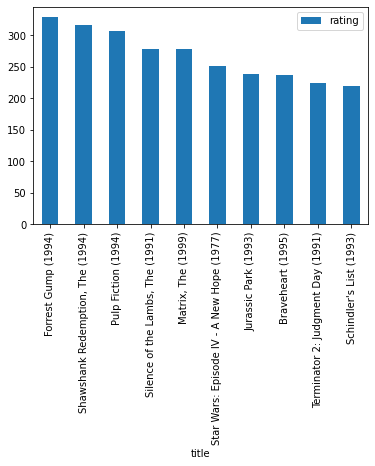

In [17]:
df_movies_ratings.groupby('title')[['rating']].count().sort_values(by='rating',ascending=False).head(10).plot(kind='bar')
plt.show()

#### Top 10 most active users giving ratings

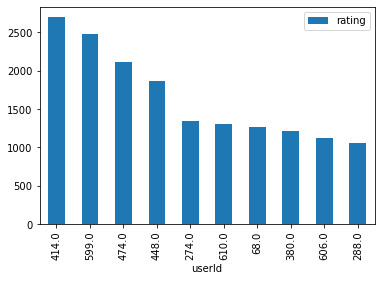

In [18]:
df_movies_ratings.groupby('userId')[['rating']].count().sort_values(by='rating',ascending=False).head(10).plot(kind='bar')
plt.show()

# Distance Based Recommendations

## Pivot Matrix - Movies

In [19]:
pivot_df_movies = pd.pivot_table(df_movies_ratings, index = 'title', columns='userId', values = 'rating').fillna(0)
pivot_df_movies.head()

userId,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,601.0,602.0,603.0,604.0,605.0,606.0,607.0,608.0,609.0,610.0
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Salem's Lot (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Til There Was You (1997),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Pairwise cosine distance

In [22]:
distance_array_movies = pairwise_distances(pivot_df_movies, metric = 'cosine')
distance_array_movies.shape

(9719, 9719)

### Distance DataFrame

In [23]:
distance_df_movies = pd.DataFrame(distance_array_movies, index = pivot_df_movies.index, columns = pivot_df_movies.index)
distance_df_movies

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.000000,1.000000,1.000000,1.000000,1.000000e+00,1.0,1.000000,1.000000,0.858347,1.000000,...,1.000000,0.657945,0.456695,0.292893,1.0,1.000000,0.860569,0.672673,1.000000,1.0
'Hellboy': The Seeds of Creation (2004),1.000000,0.000000,0.292893,1.000000,1.000000e+00,1.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.0
'Round Midnight (1986),1.000000,0.292893,0.000000,1.000000,1.000000e+00,1.0,0.823223,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.0
'Salem's Lot (2004),1.000000,1.000000,1.000000,0.000000,1.425071e-01,1.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.0
'Til There Was You (1997),1.000000,1.000000,1.000000,0.142507,2.220446e-16,1.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.0,0.788533,0.783705,0.902065,0.867511,...,1.000000,1.000000,1.000000,1.000000,1.0,0.000000,0.807741,1.000000,0.829659,1.0
xXx (2002),0.860569,1.000000,1.000000,1.000000,1.000000e+00,1.0,0.910366,1.000000,0.723488,0.980138,...,0.930284,0.694465,0.826849,0.753518,1.0,0.807741,0.000000,0.729966,0.899604,1.0
xXx: State of the Union (2005),0.672673,1.000000,1.000000,1.000000,1.000000e+00,1.0,1.000000,1.000000,0.843236,1.000000,...,1.000000,0.617457,0.822162,0.768545,1.0,1.000000,0.729966,0.000000,1.000000,1.0


### Function to return similar movies

In [72]:
def get_similar_movies(movie):
    result = distance_df_movies[movie].nsmallest(n=11)
    return result.reset_index(name='similarity_index').query("title != @movie").set_index('title')

### Get top 10 similar movies to given movie

In [74]:
print("===================================")
print("Movie titles similar to : ")
movie_name = input()
print("===================================")
get_similar_movies(movie_name)

Movie titles similar to 


 Benji the Hunted (1987)


,similarity_index
title,
Benji (1974),0.209309
Band of the Hand (1986),0.219131
Body Parts (1991),0.219131
Caligula (1979),0.219131
Carnosaur 3: Primal Species (1996),0.219131
Denise Calls Up (1995),0.219131
"Gate, The (1987)",0.219131
Halloween 4: The Return of Michael Myers (1988),0.219131
"Man with the Golden Arm, The (1955)",0.219131


## Pivot Matrix - Users

In [56]:
pivot_df_users = pd.pivot_table(df_movies_ratings, index = 'userId', columns='movieId', values = 'rating').fillna(0)
pivot_df_users.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Pairwise cosine distance

In [57]:
distance_array_users = pairwise_distances(pivot_df_users, metric = 'cosine')
distance_array_users.shape


(610, 610)

### Distance DataFrame

In [58]:
distance_df_users = pd.DataFrame(distance_array_users, index = pivot_df_users.index, columns = pivot_df_users.index)
distance_df_users

userId,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,601.0,602.0,603.0,604.0,605.0,606.0,607.0,608.0,609.0,610.0
userId,,,,,,,,,,,,,,,,,,,,,
1.0,0.000000,9.727171e-01,9.402797e-01,8.056052e-01,0.870920,0.871848,0.841256,0.863032,0.935737,0.983125,...,0.919446,0.835545,0.778514,0.929331,0.846375,8.358085e-01,7.306108e-01,0.708903,9.064281e-01,0.854679
2.0,0.972717,1.110223e-16,1.000000e+00,9.962741e-01,0.983386,0.974667,0.972415,0.972743,1.000000,0.932555,...,0.797329,0.983134,0.988003,1.000000,1.000000,9.715710e-01,9.870521e-01,0.953789,9.724346e-01,0.897573
3.0,0.940280,1.000000e+00,1.110223e-16,9.977486e-01,0.994980,0.996064,1.000000,0.995059,1.000000,1.000000,...,0.994952,0.995108,0.975008,1.000000,0.989306,9.870070e-01,9.807532e-01,0.978872,1.000000e+00,0.967881
4.0,0.805605,9.962741e-01,9.977486e-01,2.220446e-16,0.871341,0.911509,0.884880,0.937031,0.988639,0.968837,...,0.914062,0.871727,0.692027,0.947015,0.915416,7.996055e-01,8.682538e-01,0.850142,9.678020e-01,0.892317
5.0,0.870920,9.833856e-01,9.949803e-01,8.713411e-01,0.000000,0.699651,0.891658,0.570925,1.000000,0.969389,...,0.931952,0.581253,0.889852,0.741227,0.851242,8.935651e-01,8.471340e-01,0.864465,7.387679e-01,0.939208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606.0,0.835809,9.715710e-01,9.870070e-01,7.996055e-01,0.893565,0.897877,0.799965,0.900612,0.924102,0.911037,...,0.821916,0.883466,0.699331,0.933968,0.851859,5.551115e-16,8.469374e-01,0.737442,9.303783e-01,0.798896
607.0,0.730611,9.870521e-01,9.807532e-01,8.682538e-01,0.847134,0.837818,0.813886,0.814858,0.988156,0.989549,...,0.907475,0.800090,0.796460,0.862166,0.881220,8.469374e-01,3.330669e-16,0.716919,8.508097e-01,0.860886
608.0,0.708903,9.537890e-01,9.788715e-01,8.501419e-01,0.864465,0.821191,0.676459,0.812767,0.899565,0.922576,...,0.841645,0.802486,0.767229,0.844694,0.821858,7.374419e-01,7.169185e-01,0.000000,8.780073e-01,0.677945


### Function to return similar users

In [76]:
def get_similar_users(user):
    num_user = pd.to_numeric(user)
    result = distance_df_users[num_user].nsmallest(n=11)
    return result.reset_index(name='similarity_index').query("userId != @num_user").set_index('userId')


### Get top 10 similar users to given user

In [78]:
print("===================================")
print("Users similar to : ")
user_id = input()
print("===================================")
get_similar_users(user_id)

Users similar to : 


 610.0


,similarity_index
userId,
249.0,0.521338
298.0,0.552503
274.0,0.564545
380.0,0.575040
305.0,0.591225
599.0,0.604068
68.0,0.609085
414.0,0.609489
561.0,0.621813
